In [1]:
#!pip install -U Flask
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

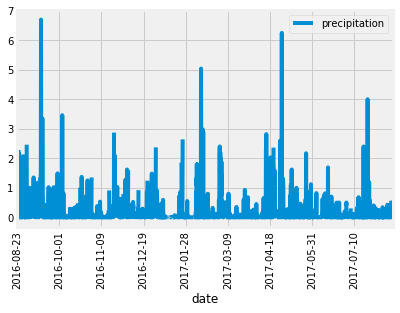

In [206]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_12m = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
hawaii_prcp_session = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_12m).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
hawaii_prcp_df = pd.DataFrame(hawaii_prcp_session, columns=['date','precipitation'])

# Sort the dataframe by date
hawaii_prcp_df_cleaned = hawaii_prcp_df.sort_values(by='date')
hawaii_prcp_df_cleaned.set_index(hawaii_prcp_df_cleaned['date'], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
hawaii_prcp_df_cleaned.plot(rot=90)

![precipitation](Images/precipitation.png)

In [98]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_prcp_df_cleaned.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [ ]:
# Design a query to show how many stations are available in this dataset?
stationcount = pd.read_sql("SELECT COUNT(name) FROM station", engine.connect())
stationcount.rename(columns={"COUNT(name)": "Station Count"})

In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
readingtally = pd.read_sql("SELECT station, COUNT(*) FROM measurement GROUP BY station;", engine.connect())

readingtally = readingtally.rename(columns={"station": "Station","COUNT(*)": "Reading Tally"})
readingtally = readingtally.sort_values("Reading Tally", axis = 0, ascending = False)
readingtally

In [176]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
High_Avg_Low_USC00519281 = pd.read_sql("""SELECT station AS StationID, MAX(tobs) as TempHigh, AVG(tobs) as TempAvg, 
                                       min(tobs) as TempLow FROM measurement WHERE station = 
                                       'USC00519281'""", engine.connect())
High_Avg_Low_USC00519281

,StationID,TempHigh,TempAvg,TempLow
0,USC00519281,85.0,71.663781,54.0


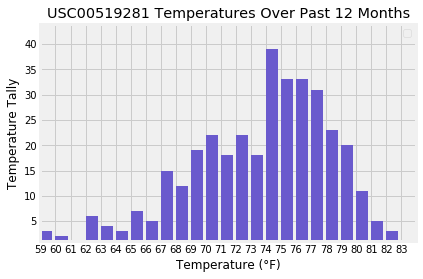

In [102]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12m_USC00519281 = dt.date(2017, 8, 18) - dt.timedelta(days=365)

USC00519281_12m_tobs_recs_session = session.query(Measurement.date, Measurement.tobs)
USC00519281_12m_tobs_recs_filter1 = USC00519281_12m_tobs_recs_session.filter(Measurement.station == "USC00519281")
USC00519281_12m_tobs_recs_final = USC00519281_12m_tobs_recs_filter1.filter(Measurement.date > last_12m_USC00519281)

temperature_grp = pd.DataFrame(USC00519281_12m_tobs_recs_final)
temperature_grp = temperature_grp.groupby('tobs').size()
temperature_grp = temperature_grp.to_frame()
temperature_grp = temperature_grp.reset_index()
temperature_grp['tobs'] = temperature_grp['tobs'].astype(int)
temperature_grp = temperature_grp.rename(columns={'tobs':'Temperature', 0:'Instances'})


y_axis = temperature_grp["Instances"]
x_axis = np.arange(len(y_axis))


tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, temperature_grp["Temperature"])
plt.xlim(0, len(x_axis))
plt.ylim(min(y_axis), max(y_axis)+5)
plt.grid(linestyle='-')
plt.title("USC00519281 Temperatures Over Past 12 Months")
plt.xlabel("Temperature (°F)")
plt.ylabel("Temperature Tally")
plt.legend(['Frequency of Tobs Value'])
bargraph = plt.bar(x_axis, y_axis, color="slateblue", alpha=1, align="edge")

![precipitation](Images/station-histogram.png)

In [156]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [185]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#AS OF THIS TIME, THE DATASET DOES NOT INCLUDE DATES FOR 2018-11-16, 2018-11-21 OR 2017-11-16, 2017-11-21
#WILL USE 2016-11-16 TO 2016-11-21 INSTEAD
trip_start = dt.date(2016, 11, 16)
trip_end = dt.date(2016, 11, 21)
triptemps = calc_temps(trip_start, trip_end)
print(triptemps)

[(71.0, 75.52941176470588, 80.0)]


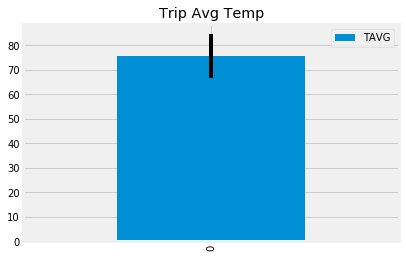

In [186]:
# Plot the results from your previous query as a bar chart. 
triptemps_df = pd.DataFrame(triptemps, columns=["TMIN","TAVG","TMAX"])
triptemps_df
# Use "Trip Avg Temp" as your Title
title = "Trip Avg Temp"
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = [triptemps_df["TMAX"]-triptemps_df["TMIN"]]
triptemps_bar = triptemps_df.plot.bar(y='TAVG',yerr=yerr, title = title)

In [200]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_duration = dt.date(2016, 11, 21) - dt.timedelta(days=5)
station_df = pd.read_sql("""SELECT station as StationID, name as Station_Name,
            latitude, longitude, elevation FROM station""", engine.connect())
trip_prcp_session = session.query(Measurement.station, Measurement.date, Measurement.prcp)
trip_prcp_session = trip_prcp_session.filter(Measurement.date <= trip_end).filter(Measurement.date >= trip_start).all()

prcp_df = pd.DataFrame(trip_prcp_session, columns=['StationID','Date','Precipitation'])
prcp_df

trip_merged_df = pd.merge(station_df, prcp_df, how="left", on=["StationID", "StationID"])
trip_merged_df.sort_values("Precipitation", axis = 0, ascending = False).dropna(axis = 0, how ='any').reset_index()

,index,StationID,Station_Name,latitude,longitude,elevation,Date,Precipitation
0,35,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2016-11-21,2.87
1,32,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2016-11-16,0.91
2,23,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2016-11-20,0.40
3,29,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2016-11-20,0.39
4,25,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2016-11-16,0.24
5,12,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2016-11-16,0.18
6,6,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2016-11-16,0.14
7,22,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2016-11-19,0.13
8,30,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2016-11-21,0.11
9,28,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2016-11-19,0.11


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Plot the daily normals as an area plot with `stacked=False`
